In [12]:
import numpy as np
import scipy.io as io
import astra
import cupy as cp
import sys
# import ptychocg as pt
import time
import matplotlib.pyplot as plt

from pycallgraph import PyCallGraph
from pycallgraph import Config
from pycallgraph.output import GraphvizOutput

config = Config(max_depth=5)
graphviz = GraphvizOutput(output_file='filter_max_depth.png')

#loading data
from skimage.transform import resize
volume = io.loadmat('layer_het300.mat')['volume']
# volume = resize(io.loadmat('layer_het300.mat')['volume'],(100,100,100))
volume = -1e-5*volume + 1j*1e-7*volume #phrased as a complex refractive index
(M,N,N) = volume.shape
probe = io.loadmat('probe_100x100.mat')['probe']
# probe = resize(np.real(probe),(30,30)) + 1j*resize(np.imag(probe),(30,30))
#define the scanning positions
nx = 2
ny = 2
ntheta = 2
angles = np.linspace(0,np.pi,ntheta)
angles_param = np.repeat(angles,nx*ny)
parameters = np.zeros([len(angles)*nx*ny,3])
parameters[:,0] = angles_param
np.random.seed(0)
for i in range(len(parameters[:,0])):
    parameters[i,1] = (np.random.rand(1)-0.5)*N
    parameters[i,2] = (np.random.rand(1)-0.5)*M
scan = parameters
#k-value for the simulated x-ray source
wavelength = 12.389e-9
dist = 5
pxsize = 172e-6
rec_pxsize = wavelength*dist/(pxsize*probe.shape[0])
wavenum = 2*np.pi/wavelength*rec_pxsize
wavenum = 2*np.pi*dist/(pxsize*probe.shape[0])

In [28]:
def fourier(image):
    f_image = np.fft.fft2(image,norm="ortho")
#     f_image = np.fft.fftshift(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(np.fft.ifftshift(image,-2),-1)),-2),-1)
#     f_image = f_image/(np.sqrt(f_image.shape[-1]*f_image.shape[-2]))
    return f_image

def i_fourier(image):
    if_image = np.fft.ifft2(image,norm="ortho")
#     if_image = np.fft.fftshift(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.fft.ifftshift(image,-2),-1)),-2),-1)
#     if_image = if_image*(np.sqrt(if_image.shape[-1]*if_image.shape[-2]))
    return if_image

def radon3D(volume, proj_geom):
    (M,N,N) = volume.shape
    vol_geom = astra.create_vol_geom(N,N,M) 
    [_,frames_r] = astra.create_sino3d_gpu(np.real(volume),proj_geom,vol_geom)
    [_,frames_i] = astra.create_sino3d_gpu(np.imag(volume),proj_geom,vol_geom)
    frames = (frames_r+1j*frames_i)
    frames = frames.transpose((1,2,0))
    astra.clear()
    return frames

def back_radon3D(frames, proj_geom, vol_shape):
    (M,N,N) = vol_shape
    vol_geom = astra.create_vol_geom(N,N,M)
    frames = np.transpose(frames,(2,0,1))
    (_,volume_r) = astra.create_backprojection3d_gpu(np.real(frames),proj_geom,vol_geom)
    (_,volume_i) = astra.create_backprojection3d_gpu(np.imag(frames),proj_geom,vol_geom)
    volume = (volume_r + 1j*volume_i)
    astra.clear()
    return volume

def probe_object(frames,probe,scan):
    PO = np.zeros([(np.shape(scan)[0]),probe.shape[0],probe.shape[1]],dtype=complex)
    for i,frame in enumerate(frames):
        PO[i] = probe*frame       
    return PO

def ptycho(frames,probe,scan):
    PO = np.zeros([(np.shape(scan)[0]),probe.shape[0],probe.shape[1]],dtype=complex)
    for i,frame in enumerate(frames):
        PO[i] = fourier(probe*frame)
    return PO

def norm(vf):
    n = np.sqrt(np.inner(np.conj(np.complex128(vf)),np.complex128(vf)))
    return n

def obj(volume, proj_geom, k):
#     obj = np.exp(1j*k*radon3D(volume, proj_geom))
    obj = 1 + 1j*k*radon3D(volume, proj_geom)
    return obj
    
def jacobian(volume,proj_geom,probe,scan,hn,k):
    Psi_conj = np.conj(ptycho(obj(volume,proj_geom,k),probe,scan))
    J_scans = 2*np.real(Psi_conj*ptycho(1j*k*radon3D(hn, proj_geom),probe,scan))
    return np.nan_to_num(J_scans)

def jacobian_adjoint(volume,proj_geom,probe,scan,hng,k):
    Obj = obj(volume,proj_geom,k)
    Psi = ptycho(Obj,probe,scan)
    psi = np.conj(probe*1j*k)
    JA_image = 2*back_radon3D(psi*i_fourier(Psi*np.real(hng)),proj_geom, volume.shape)
    return np.nan_to_num(JA_image)

#initialize vectors for ASTRA
vectors = np.zeros((np.shape(scan)[0],12))
vectors[:,0]=np.sin(scan[:,0])                                         #rayX
vectors[:,1]=-np.cos(scan[:,0])                                        #rayY
vectors[:,2]=0                                                         #rayZ
vectors[:,3]=np.multiply(scan[:,1],np.cos(scan[:,0]))                  #dX
vectors[:,4]=np.multiply(scan[:,1],np.sin(scan[:,0]))                  #dY
vectors[:,5]=scan[:,2]                                                 #dZ
vectors[:,6]=np.cos(scan[:,0])                                         #uX
vectors[:,7]=np.sin(scan[:,0])                                         #uY
vectors[:,8]=0                                                         #uZ
vectors[:,9]=0                                    #vX
vectors[:,10]=0                                   #vY
vectors[:,11]=1                                   #vZ
#create projection geometry with astra
proj_geom = astra.create_proj_geom('parallel3d_vec',probe.shape[0],probe.shape[1],vectors)

In [29]:
Rf = jacobian(volume,proj_geom,probe,scan,volume*0+1e-6,wavenum)

In [30]:
RtRf = jacobian_adjoint(volume,proj_geom,probe,scan,Rf,wavenum)

In [31]:
np.min(Rf.real)

-31626.160504300733

<IPython.core.display.Javascript object>


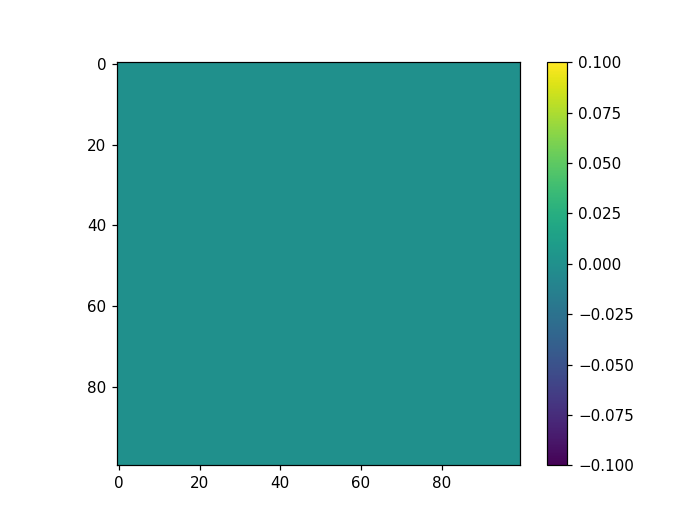

In [22]:
%matplotlib notebook
plt.figure()
plt.imshow(np.imag(Rf)[4,:,:])
plt.colorbar()

In [ ]:
data = np.sqrt(np.abs(ptycho(obj(volume,proj_geom,wavenum),probe,scan))**2)
recon = np.zeros(volume.shape,dtype=complex)
guess_data = np.sqrt(np.abs(ptycho(obj(recon, proj_geom,wavenum),probe,scan))**2)

with PyCallGraph(output=graphviz, config=config):
    #parameters for LMA:
#     del volume
    mu0 = -1 #set negative to calculate automatically
    ni_LMA = 2
    ni_CGM = 2

    #start the actual algorithm
    mu = mu0
    k = 0
    v = 2 #used for mu update
    r_LMA = data - guess_data #initial residual

    while k<ni_LMA:
        try:           
            t_start = time.time()
            #predefining parts of the (jacobian) and jacobian adjoint that will stay constant during an iteration of LMA
            g = jacobian_adjoint(recon,proj_geom,probe,scan,r_LMA,wavenum)

            if mu<0:
                mu = norm(g.flatten())
            print("Mu is",mu)

            #anonymous function as the operator for CGM (laplacian for total varriation)
            A = lambda h1:jacobian_adjoint(recon,proj_geom,probe,scan,jacobian(recon,proj_geom,probe,scan,h1,wavenum),wavenum) + mu*h1
                                                                        
            #CGM initialization
            h = recon*0        
            r = g-A(h)
            p = r

            for j in range(ni_CGM):
                #this operation takes a long time, so it makes sense to save it.
                AP = A(p)
                alpha = np.inner(np.conj(r.flatten()),r.flatten())/np.real(np.inner(np.conj(p.flatten()),AP.flatten()))
                dh = alpha*p
                h = h + dh
                r2 = r - alpha*AP
                beta = np.inner(np.conj(r2.flatten()),(r2.flatten()-r.flatten()))/np.inner(np.conj(r.flatten()),r.flatten()) #Polak-Ribiére
                r=r2
                p = r + beta*p
                print("Did iteration {} of {} in CGM".format(j+1,ni_CGM))
            #here the reconstruction is updated completing the iteration of LMA
            recon = recon + h
            #nonnegativity
            recon = -np.abs(np.real(recon))+1j*np.maximum(np.imag(recon),0)
            #memory management
            del r,r2, p, dh, alpha, beta, AP 
            #here rho is updated. Rho is used to update mu
            r_LMA2 = data-np.sqrt(np.abs(ptycho(obj(recon,proj_geom,wavenum),probe,scan))**2)
            rho = (norm(r_LMA.flatten())**2 - norm(r_LMA2.flatten())**2)/np.real(np.inner(np.conj(h.flatten()),(mu*h+g).flatten()))
            del h #memory management
            #mu update for next iteration.
            if rho > 0:
                mu=mu*np.max([1/3,1-(2*rho-1)**3])
                v=2
                print("Mu is",mu)
            else:
                mu = mu*v
                v=2*v
                print("Mu is",mu)
            r_LMA = r_LMA2
            np.save("recon.npy",recon)
            print("Did iteration {} of {} in LMA.".format(k+1,ni_LMA))
            print("This iteration took {} s. Reconstruction has been saved as recon.npy".format(np.round(time.time()-t_start)))
            k=k+1
        except KeyboardInterrupt:
            print("KEYBOARD INTERUPT DETECTED! Current reconstruction is saved as recon.npy")
            raise